In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models, datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torchvision import datasets

In [12]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [13]:
!unzip -qq ./chip_data.zip -d data

In [14]:
dataset_path = "./data/dataset/"
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test", transform=transform)

In [15]:
def show_sample_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(5, 5))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)  # Convert tensor format (C, H, W) to (H, W, C)
        axes[i].imshow(image)
        axes[i].set_title(dataset.classes[label])
        axes[i].axis("off")
    plt.show()

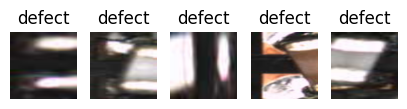

In [16]:
show_sample_images(train_dataset)

In [17]:
print(f"Total number of training samples: {len(train_dataset)}")

# Get the shape of the first image in the dataset
first_image, label = train_dataset[0]
print(f"Shape of the first image: {first_image.shape}")

Total number of training samples: 172
Shape of the first image: torch.Size([3, 224, 224])


In [18]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [19]:
model = models.vgg19(weights = models.VGG19_Weights.DEFAULT)
for param in model.parameters():
  param.requires_grad = False


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:03<00:00, 158MB/s]


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [21]:
from torchsummary import summary
# Print model summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [22]:
num_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_features,1)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
summary(model, input_size=(3, 224, 224))
# Freeze all layers except the final layer
for param in model.features.parameters():
    param.requires_grad = False  # Freeze feature extractor layers

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [24]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [25]:

def train_model(model, train_loader,test_loader,num_epochs=10):
    train_losses = []
    val_losses = []
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.unsqueeze(1).float()  # Reshape labels to [batch_size, 1] and convert to float
            optimizer.zero_grad()
            outputs = model(images)
            outputs = torch.sigmoid(outputs) # Apply sigmoid here
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Compute validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels = labels.unsqueeze(1).float()  # Reshape labels to [batch_size, 1] and convert to float
                outputs = model(images)
                outputs = torch.sigmoid(outputs) # Apply sigmoid here
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(test_loader))
        model.train()

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

    # Plot training and validation loss
    print("Name:Dhanuja M")
    print("Register Number:212224230057")
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Epoch [1/10], Train Loss: 0.5730, Validation Loss: 0.4503
Epoch [2/10], Train Loss: 0.4874, Validation Loss: 0.3732
Epoch [3/10], Train Loss: 0.3920, Validation Loss: 0.3458
Epoch [4/10], Train Loss: 0.3343, Validation Loss: 0.3009
Epoch [5/10], Train Loss: 0.3375, Validation Loss: 0.2828
Epoch [6/10], Train Loss: 0.2651, Validation Loss: 0.2679
Epoch [7/10], Train Loss: 0.2355, Validation Loss: 0.2537
Epoch [8/10], Train Loss: 0.2536, Validation Loss: 0.2463
Epoch [9/10], Train Loss: 0.2208, Validation Loss: 0.2383
Epoch [10/10], Train Loss: 0.2036, Validation Loss: 0.2338
Name:Dhanuja M
Register Number:212224230057


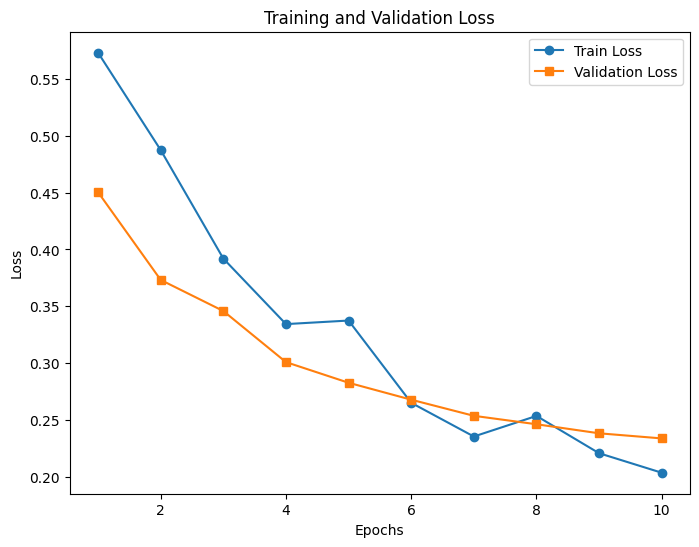

In [27]:
# Train the model for a specified number of epochs
num_epochs = 10  # You can adjust the number of epochs as needed
train_model(model, train_loader, test_loader,num_epochs)


In [28]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # Apply sigmoid and threshold for binary prediction
            predicted = (torch.sigmoid(outputs) > 0.5).int() # Sigmoid is already applied in train_model, so apply here too
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item() # Reshape labels to [batch_size, 1] for comparison
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')


    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Name:Dhanuja M")
    print("Register Number:212224230057")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print("Name:Dhanuja M")
    print("Register Number:212224230057")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))



Test Accuracy: 0.9421
Name:Dhanuja M
Register Number:212224230057


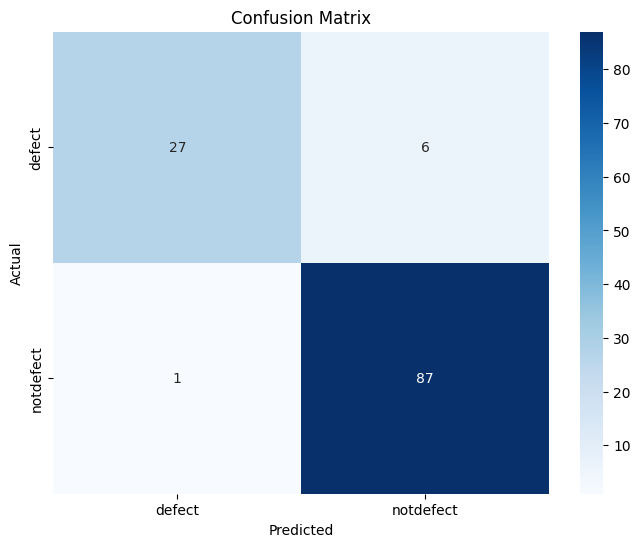

Name:Dhanuja M
Register Number:212224230057
Classification Report:
              precision    recall  f1-score   support

      defect       0.96      0.82      0.89        33
   notdefect       0.94      0.99      0.96        88

    accuracy                           0.94       121
   macro avg       0.95      0.90      0.92       121
weighted avg       0.94      0.94      0.94       121



In [29]:
test_model(model, test_loader)

In [30]:
def predict_image(model, image_index, dataset):
    model.eval()
    image, label = dataset[image_index]
    with torch.no_grad():
        image_tensor = image.unsqueeze(0).to(device)
        output = model(image_tensor)

        # Apply sigmoid to get probability, threshold at 0.5
        prob = torch.sigmoid(output)
        predicted = (prob > 0.5).int().item()


    class_names = class_names = dataset.classes
    # Display the image
    image_to_display = transforms.ToPILImage()(image)
    plt.figure(figsize=(4, 4))
    plt.imshow(image_to_display)
    plt.title(f'Actual: {class_names[label]}\nPredicted: {class_names[predicted]}')
    plt.axis("off")
    plt.show()

    print(f'Actual: {class_names[label]}, Predicted: {class_names[predicted]}')

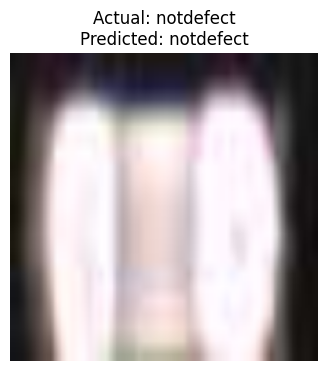

Actual: notdefect, Predicted: notdefect


In [32]:

predict_image(model, image_index=45, dataset=test_dataset)

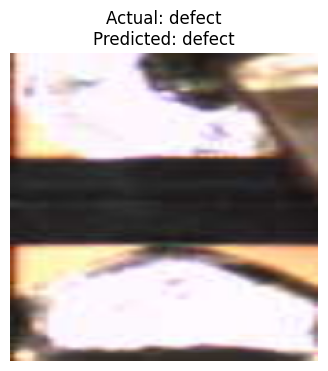

Actual: defect, Predicted: defect


In [33]:
predict_image(model, image_index=20, dataset=test_dataset)